In [17]:
import math
import numpy as np
from scipy.special import erfinv
import numpy.random as rng
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class Generator_eye(object):
    def __init__(self, p, theta, beta_range) -> None:
        self.p = p 
        self.theta = theta 
        self.beta_range = beta_range 
        self.X = np.eye(p)
    
    def generate_samples(self, n):
        scale = self.beta_range[1] - self.beta_range[0]
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.rand(np.sum(gamma == 1)) * scale + self.beta_range[0]
        beta[gamma == 0] = 0. 
        Y = beta@self.X.T + rng.randn(n, self.p)
        return gamma, beta, Y 

## Neural Networks

In [7]:
class MLP_light(nn.Module):
    def __init__(self, N, p):
        super(MLP_light, self).__init__()
        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()
    
    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        output = self.fc3(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss
    
    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss

## Relative functions

In [58]:
''' 
 loss_type: 'mse' for posterior mean, 'bce' for predicting whether beta is 0, 'quantile' for posterior quantile.
q: Only used when loss_type is 'quantile', q quantile.
'''
def train_epoch(model, optimizer, data_loader, loss_type, q):
    model.train()
    n = 0
    train_loss = 0.
    for _, (data, targ) in enumerate(data_loader):
        data, targ = data.to(device), targ.to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
        train_loss += loss.item() * data.shape[0]   
        n += data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/n
             
def model_test(model, data_loader, loss_type='mse', q=0.5):
    model.eval()
    with torch.no_grad():
        n = 0 
        total_loss = 0.
        for _, (data, targ) in enumerate(data_loader):
            data, targ = data.to(device), targ.to(device)
            if loss_type == 'mse':
                loss = model.get_mseloss(data, targ)
            elif loss_type == 'bce':
                loss = model.get_bceloss(data, targ)
            elif loss_type == 'quantile':
                loss = model.get_quanloss(data, targ, q)
            total_loss += loss.item() * data.shape[0]
            n += data.shape[0]
    return total_loss/n

def train_model(model, model_es, lr, epochs, train_data, loss_type='mse', q=0.5, val_data=None, early_stop=5):
    assert loss_type in ['mse', 'bce', 'quantile']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    min_loss = 1e6
    es_count = 0
    es_flag = 0
    for i in range(epochs):
        train_loss = train_epoch(model, optimizer, train_data, loss_type, q)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if val_data.__str__() != 'None':
            val_loss = model_test(model, val_data, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
            if val_loss <= min_loss:
                min_loss = val_loss
                es_count = 0
            if (es_count >= early_stop) and (es_flag == 0):
                es_flag = 1
                print('Save early stopping model at epoch {}'.format(i+1))
                model_es.load_state_dict(deepcopy(model.state_dict()))
            es_count += 1
    return train_losses, val_losses

def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

def show_loss(train_losses, val_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(train_losses)), val_losses)
    plt.legend(['train loss', 'val loss'], loc="upper right")
    plt.show()

def predict_class(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = torch.sigmoid(model(data))
    return pred.detach().cpu().numpy()

In [28]:
''' 
compute normalization constant
'''
def compute_c(y, theta, a, sigma):
    c = 2*a * (1-theta) * np.exp(-y**2 / (2 * sigma**2)) \
    + theta * np.sqrt(np.pi/2) * sigma * \
    (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-a)/(sigma*np.sqrt(2))))
    return c / (2*a)

In [29]:
''' 
compute the cumulative probablity of the marginal distribution of beta
'''
def cumulative_prob(t, y, norm_c, theta, a, sigma):
    assert t>=-a and t<=a
    if t>=0:
        prob = (1-theta) * np.exp(-y**2 / (2 * sigma**2)) / norm_c \
            + theta * np.sqrt(np.pi/2) * sigma * \
                (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-t)/(sigma*np.sqrt(2)))) / (2 * a * norm_c)
    elif t<0:
        prob = theta * np.sqrt(np.pi/2) * sigma * \
                (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-t)/(sigma*np.sqrt(2)))) / (2 * a * norm_c)
    return prob

In [30]:
def computeQuantile(y, norm_c, theta, a, sigma, q=0.975):
    inner = ((1-theta) / norm_c * np.exp(-y**2 / (2 * sigma**2)) - q) \
        / (theta / (2*a*norm_c) * np.sqrt(np.pi/2) * sigma) + math.erf((y+a)/(sigma*np.sqrt(2)))
    t = y - np.sqrt(2) * sigma * erfinv(inner)
    return t 
def computePPI(y, theta, a, sigma):
    q025 = q975 = 0
    c = compute_c(y, theta, a, sigma)
    abs_y = np.abs(y)
    if abs_y >= 1.68:
        q975 = computeQuantile(abs_y, c, theta, a, sigma, 0.975)
    if abs_y >= 4.168:
        q025 = computeQuantile(abs_y, c, theta, a, sigma, 0.025)
    if y < 0:
        temp = q025
        q025 = -q975
        q975 = -temp 
    return q025, q975
def computePosMean(y, theta, a, sigma):
    c = compute_c(y, theta, a, sigma)
    left = sigma**2 * (np.exp(-((-a-y)/np.sqrt(2)/sigma)**2) - np.exp(-((a-y)/np.sqrt(2)/sigma)**2))
    right = np.sqrt(np.pi/2) * sigma * y * \
        (math.erf((a-y)/(sigma*np.sqrt(2))) - math.erf((-a-y)/(sigma*np.sqrt(2))))
    mu = theta / (2*a*c) * (left + right)
    return mu 

In [57]:
def compute_mses(md_mean, md_q025, md_q975, Y, Y_normalized, theta, a, sigma):
    true_mean = np.zeros_like(Y)
    true_q025 = np.zeros_like(Y)
    true_q975 = np.zeros_like(Y)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            true_mean[i,j] = computePosMean(Y[i,j], theta, a, sigma)
            true_q025[i,j], true_q975[i,j] = computePPI(Y[i,j], theta, a, sigma)
    pred_mean = predict(md_mean, Y_normalized)
    pred_q025 = predict(md_q025, Y_normalized)
    pred_q975 = predict(md_q975, Y_normalized)
    mse_mean = np.mean((pred_mean-true_mean)**2)
    mse_q025 = np.mean((pred_q025-true_q025)**2)
    mse_q975 = np.mean((pred_q975-true_q975)**2)
    return mse_mean, mse_q025, mse_q975

## Experiments

In [59]:
p = 10
theta = 0.05
a = 10
sigma = 1
lr = 0.001 # learning rate
max_epoch = 40
generator = Generator_eye(p, theta, (-a,a))

rng.seed(0)
gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
gamma_val, beta_val, Y_val = generator.generate_samples(10000)

rng.seed(1)
gamma_test, beta_test, Y_test = generator.generate_samples(10000)

mean = Y_train.mean(0)
std = Y_train.std(0)
Y_train = (Y_train - mean) / std 
Y_val = (Y_val - mean) / std 
train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

Y_test_normalized = (Y_test - mean) / std 

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

md_mean = MLP_light(p, p).to(device)
md_mean_es = MLP_light(p, p).to(device)
train_losses, val_losses = train_model(md_mean, md_mean_es, lr, max_epoch, train_dataloader, val_data=valid_dataloader)
show_loss(train_losses, val_losses)
torch.save(md_mean.state_dict(), './model/mean_p'+str(p)+'.pt')
torch.save(md_mean_es.state_dict(), './model/mean_p'+str(p)+'_es.pt')

md_q025 = MLP_light(p, p).to(device)
md_q025_es = MLP_light(p, p).to(device)
train_losses, val_losses = train_model(md_q025, md_q025_es, lr, max_epoch, train_dataloader, 
                                        loss_type='quantile', q=0.025, val_data=valid_dataloader)
show_loss(train_losses, val_losses)
torch.save(md_q025.state_dict(), './model/q025_p'+str(p)+'.pt')
torch.save(md_q025_es.state_dict(), './model/q025_p'+str(p)+'_es.pt')

md_q975 = MLP_light(p, p).to(device)
md_q975_es = MLP_light(p, p).to(device)
train_losses, val_losses = train_model(md_q975, md_q975_es, lr, max_epoch, train_dataloader, 
                                        loss_type='quantile', q=0.975, val_data=valid_dataloader)
show_loss(train_losses, val_losses)
torch.save(md_q975.state_dict(), './model/q975_p'+str(p)+'.pt')
torch.save(md_q975_es.state_dict(), './model/q975_p'+str(p)+'_es.pt')

compute_mses(md_mean_es, md_q025_es, md_q975_es, Y_test, Y_test_normalized, theta, a, sigma)

Epoch: 1
Train loss: 0.13041
Val loss: 0.11409
Epoch: 2
Train loss: 0.11188
Val loss: 0.11170
Epoch: 3
Train loss: 0.10990
Val loss: 0.11059
Epoch: 4
Train loss: 0.10886
Val loss: 0.11090
Epoch: 5
Train loss: 0.10816
Val loss: 0.11083


KeyboardInterrupt: 

In [56]:
a = 10
b = './model_p' + str(a) + '.pt'
b

'./model_p10.pt'

In [10]:
generator_eye = Generator_eye(p=10, theta=0.05, beta_range=(-10,10))

In [11]:
rng.seed(0)
gamma_train, beta_train, Y_train = generator_eye.generate_samples(1000000)
gamma_val, beta_val, Y_val = generator_eye.generate_samples(10000)

In [39]:
rng.seed(1)
gamma_test, beta_test, Y_test = generator_eye.generate_samples(10000)

In [12]:
mean = Y_train.mean(0)
std = Y_train.std(0)
Y_train = (Y_train - mean) / std 
Y_val = (Y_val - mean) / std 
train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

In [40]:
Y_test_normalized = (Y_test - mean) / std 

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

In [14]:
md = MLP_light(10, 10).to(device)
train_losses, val_losses = train_model(md, 0.001, 20, train_dataloader, val_data=valid_dataloader)

Epoch: 1
Train loss: 0.13017
Val loss: 0.11855
Epoch: 2
Train loss: 0.11183
Val loss: 0.11297
Epoch: 3
Train loss: 0.10996
Val loss: 0.11107
Epoch: 4
Train loss: 0.10881
Val loss: 0.11047
Epoch: 5
Train loss: 0.10826
Val loss: 0.11108
Epoch: 6
Train loss: 0.10770
Val loss: 0.10940
Epoch: 7
Train loss: 0.10733
Val loss: 0.10917
Epoch: 8
Train loss: 0.10705
Val loss: 0.10980
Epoch: 9
Train loss: 0.10678
Val loss: 0.10954
Epoch: 10
Train loss: 0.10653
Val loss: 0.10996
Epoch: 11
Train loss: 0.10632
Val loss: 0.10877
Epoch: 12
Train loss: 0.10622
Val loss: 0.11096
Epoch: 13
Train loss: 0.10605
Val loss: 0.10881
Epoch: 14
Train loss: 0.10579
Val loss: 0.10906
Epoch: 15
Train loss: 0.10568
Val loss: 0.11005
Epoch: 16
Train loss: 0.10557
Val loss: 0.10790
Epoch: 17
Train loss: 0.10545
Val loss: 0.10826
Epoch: 18
Train loss: 0.10532
Val loss: 0.10895
Epoch: 19
Train loss: 0.10513
Val loss: 0.10902
Epoch: 20
Train loss: 0.10501
Val loss: 0.10729


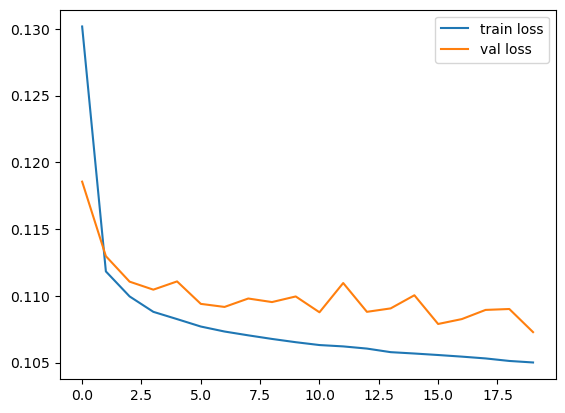

In [18]:
show_loss(train_losses, val_losses)

In [41]:
pred_mean = predict(md, Y_test_normalized)

In [42]:
np.mean((pred_mean-beta_test)**2)

0.10406858668109009

In [43]:
true_mean = np.zeros_like(Y_test)
for i in range(Y_test.shape[0]):
    for j in range(Y_test.shape[1]):
        true_mean[i,j] = computePosMean(Y_test[i,j], 0.05, 10, 1)

In [44]:
np.mean((pred_mean-true_mean)**2)

0.005195776815775464